In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [123]:
import loompy
import cytograph as cg 
import pandas as pd
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import TSNE

In [12]:
def loompy2data(filename):
    ds = loompy.connect(filename)
    return pd.DataFrame(data=ds[:,:], columns=ds.col_attrs['CellID'], index=ds.row_attrs['Gene']).astype(int)

def loompy2annot(filename):
    ds = loompy.connect(filename)
    return pd.DataFrame( ds.col_attrs, index=ds.col_attrs['CellID'] ).T

def loompy2data_annot(filename):
    ds = loompy.connect(filename)
    return (pd.DataFrame(data=ds[:,:],
                        columns=ds.col_attrs['CellID'],
                        index=ds.row_attrs['Gene']).astype(int),
            pd.DataFrame( ds.col_attrs,
                         index=ds.col_attrs['CellID'] ).T )

In [14]:
fname = "/data2/loom_files/development/combined/E7-8_ensemble.loom"

AttributeError: module 'cytograph' has no attribute 'QC'

In [35]:
ds = loompy.connect(fname)
sum(ds.col_attrs["Low_expression_flag"])

2017-01-13 15:33:43,321 - INFO - Connecting to: /data2/loom_files/development/combined/E7-8_ensemble.loom


0

In [47]:
df, annotations = loompy2data_annot(fname)

2017-01-13 15:46:12,715 - INFO - Connecting to: /data2/loom_files/development/combined/E7-8_ensemble.loom


In [48]:
low_complexity_flag = annotations.ix["Low_complexity_flag"]
low_expression_flag = annotations.ix["Low_expression_flag"]

In [49]:
included_flag = ~(low_expression_flag | low_complexity_flag)

In [50]:
df = df.ix[:,included_flag]
annotations = annotations.ix[:,included_flag]

In [51]:
sum(included_flag), len(included_flag)

(20744, 20820)

In [72]:
total_gene = np.sum(df.values,1)

In [60]:
total_expressing = (df.values>0).sum(1)

In [73]:
df = df.ix[(total_gene>8)&(total_expressing>4),:]

In [74]:
# Fitting CVvsMean noise model
mu = df.values.mean(1)
sigma = df.values.std(1, ddof=1)
cv = sigma/mu
score, mu_linspace, cv_fit , fitted_fun = cg.bi_pca.fit_CV(mu,cv, 'SVR', svr_gamma=0.005)

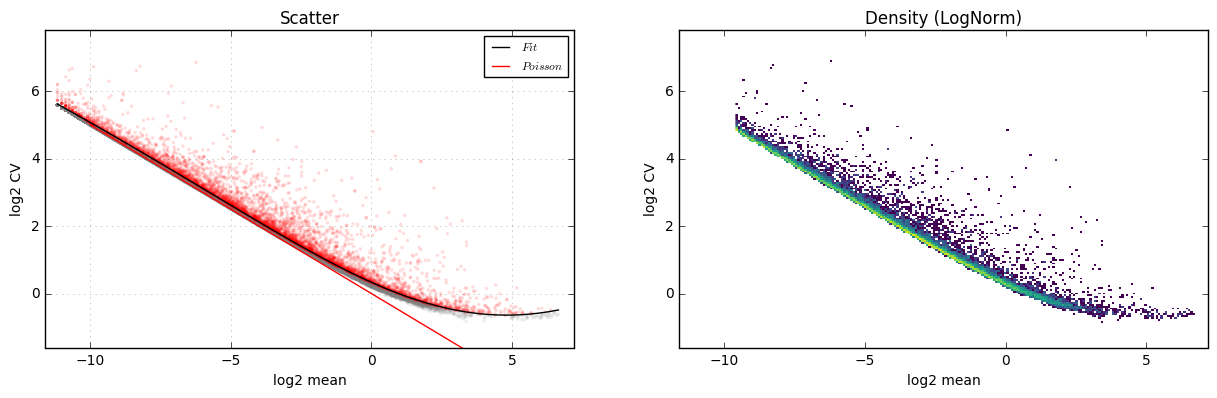

In [105]:
#Plotting
from matplotlib.colors import LogNorm
thrs = 5000
figure(figsize=(15,15))

subplot(121)

mu_sorted = mu[argsort(score)[::-1]]
cv_sorted = cv[argsort(score)[::-1]]
scatter(log2(mu_sorted[thrs:]),log2(cv_sorted[thrs:]), marker='o', edgecolor ='none',alpha=0.14, s=6, c='gray')
scatter(log2(mu_sorted[:thrs]),log2(cv_sorted[:thrs]), marker='o', edgecolor ='none',alpha=0.14, s=6, c='r')
plot(mu_linspace, cv_fit,'-k', linewidth=1, label='$Fit$')
plot(linspace(-10,7), -0.5*linspace(-10,7), '-r', label='$Poisson$')
#Adjusting plot
ylabel('log2 CV')
xlabel('log2 mean')
grid(alpha=0.3)
xlim(-11.6,7.2)
ylim(-1.6,7.8)
legend(loc=1, fontsize='small')
title('Scatter')
gca().set_aspect(1.2)

subplot(122)
hist2d(log2(mu_sorted),log2(cv_sorted), bins=[200,170],
       range=[[-9.6,6.7],[-1.6,7.8]], norm=LogNorm(),cmap=cm.viridis);
xlim(-11.6,7.2)
ylim(-1.6,7.8)
#legend(loc=1, fontsize='small')
#Adjusting plot
ylabel('log2 CV')
xlabel('log2 mean')
title('Density (LogNorm)')
gca().set_aspect(1.2)

In [106]:
len(set(feature_selected)), len(feature_selected)

(5000, 5000)

In [107]:
feature_selected = df.index[argsort(score)[::-1]][:5000]

In [108]:
data = df.ix[feature_selected,:].values

In [109]:
data_tmp = np.log2(data + 1)
data_tmp -= data_tmp.mean(1)[:, None]

In [150]:
cg.bi_pca.quick_pca??

In [111]:
#Performing PCS
pcs= cg.bi_pca.quick_pca(data_tmp,200,20000)

In [155]:
from sklearn.decomposition import PCA
pca2 = PCA(n_components=50, whiten=False)
pcs2 = pca2.fit_transform( data_tmp.T ).T

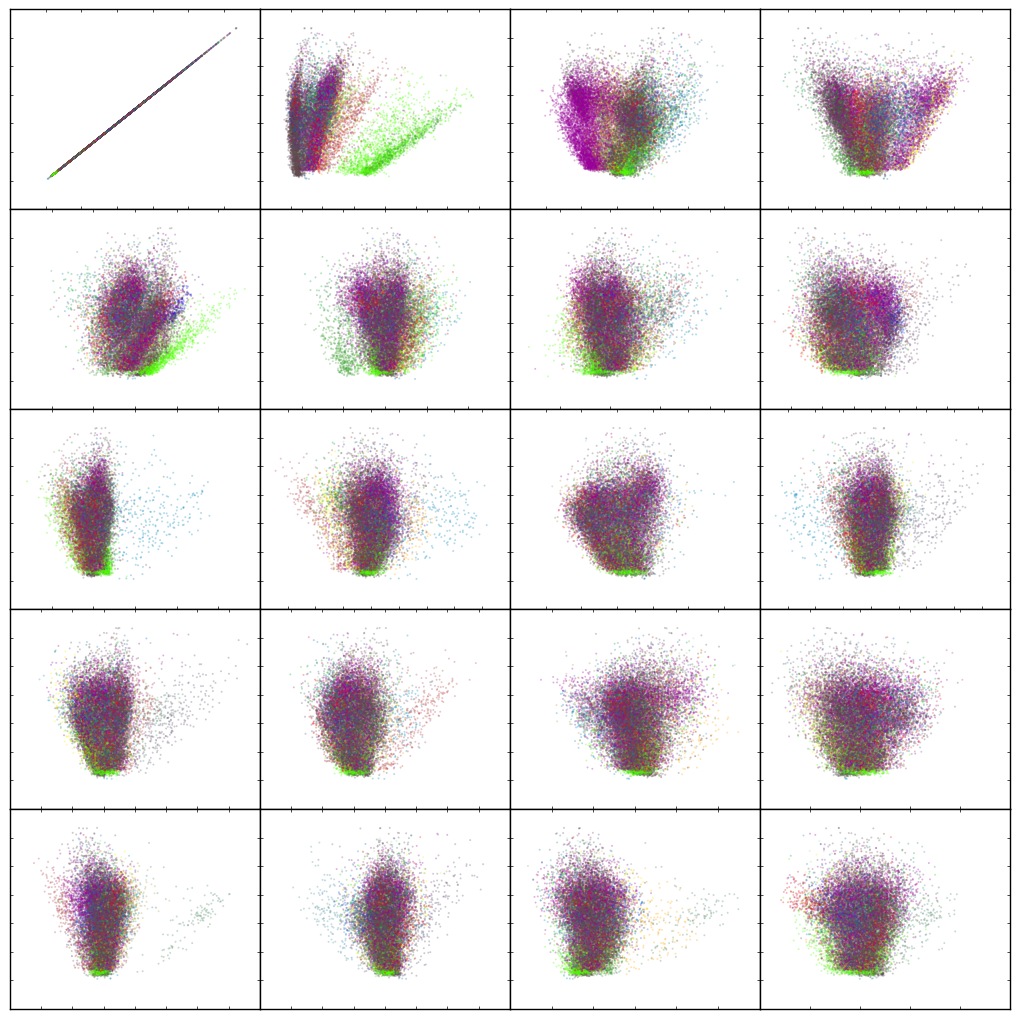

In [156]:
figure( figsize=(10,10))
#couple_pcs = list(combinations(range(6),2))
ccc = 0.3*cm.prism(labels/max(labels)) + 0.7*cm.spectral(labels/max(labels))
for i, a in enumerate(range(20)):
    ax = subplot(5,4,i+1)
    scatter(  pcs2[i,:],pcs2[0,:],s=2, c=ccc, lw=0, alpha=0.3)
    ax.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False, size=2)
    
tight_layout(pad=0.01, h_pad=0.01, w_pad=0.01)

In [163]:
from sklearn.decomposition import PCA, FactorAnalysis
fa = FactorAnalysis(n_components=50 )
fcs = fa.fit_transform( data_tmp.T ).T

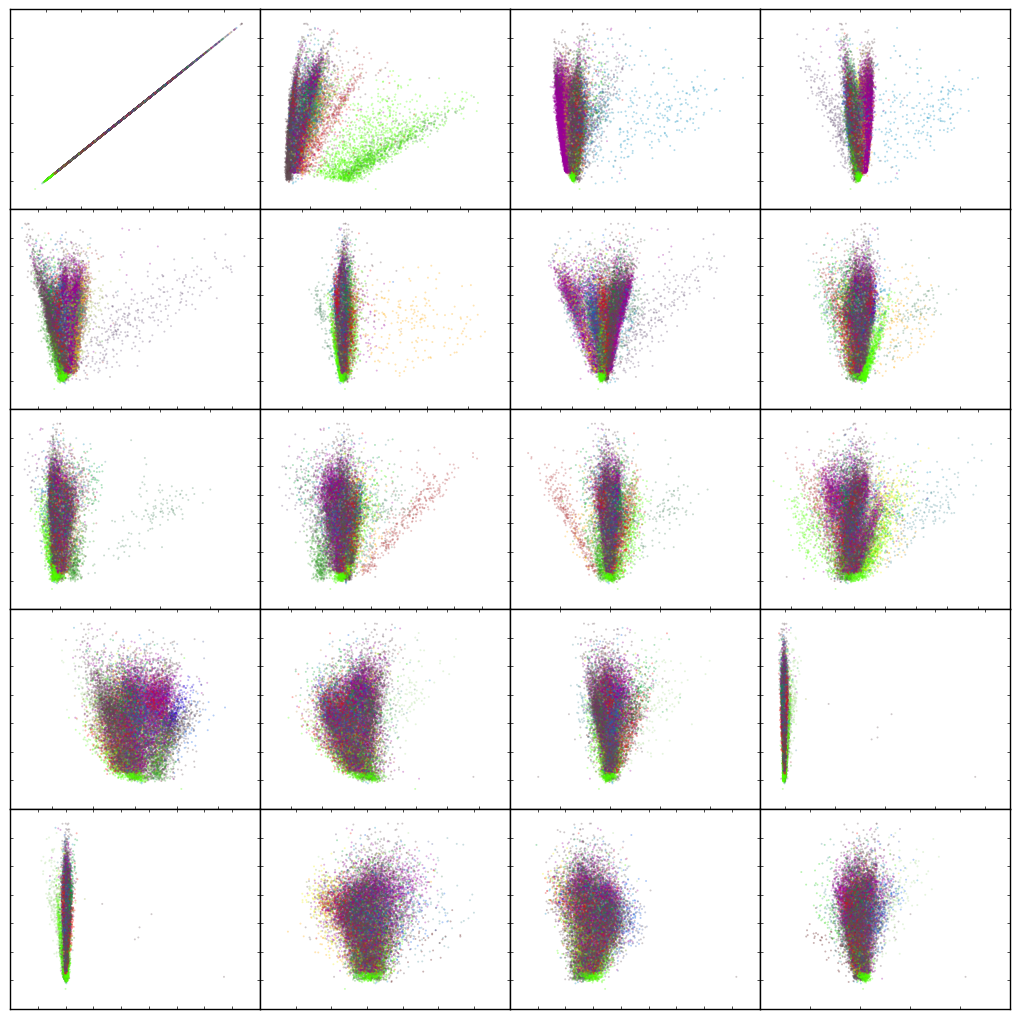

In [164]:
figure( figsize=(10,10))
#couple_pcs = list(combinations(range(6),2))
ccc = 0.3*cm.prism(labels/max(labels)) + 0.7*cm.spectral(labels/max(labels))
for i, a in enumerate(range(20)):
    ax = subplot(5,4,i+1)
    scatter(  fcs[i,:],fcs[0,:],s=2, c=ccc, lw=0, alpha=0.3)
    ax.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False, size=2)
    
tight_layout(pad=0.01, h_pad=0.01, w_pad=0.01)

In [165]:
# KNN graph generation and clustering
knn = kneighbors_graph(fcs.T, mode='distance', n_neighbors=25)
knn = knn.tocoo()

In [166]:
# Louvain-Jaccard clustering
lj = cg.LouvainJaccard(resolution=1.0)
labels = lj.fit_predict(knn)

# Make labels for excluded cells == -1
#labels_all = np.zeros(ds.shape[1], dtype='int') + -1
#labels_all[cells] = labels

In [167]:
# Mutual KNN
mknn = knn.minimum(knn.transpose()).tocoo()

In [159]:
pcs.T.shape

(20744, 200)

In [160]:
# t-SNE layout
tsne_pos = TSNE(init=fcs.T[:, :2], perplexity=30, ).fit_transform(pcs.T[:,:5])
#tsne_all = np.zeros((ds.shape[1], 2), dtype='int') + np.min(tsne_pos, axis=0)
#tsne_all[cells] = tsne_pos

KeyboardInterrupt: 

In [134]:
pcs.shape, tsne_pos.shape

((200, 20744), (20744, 2))

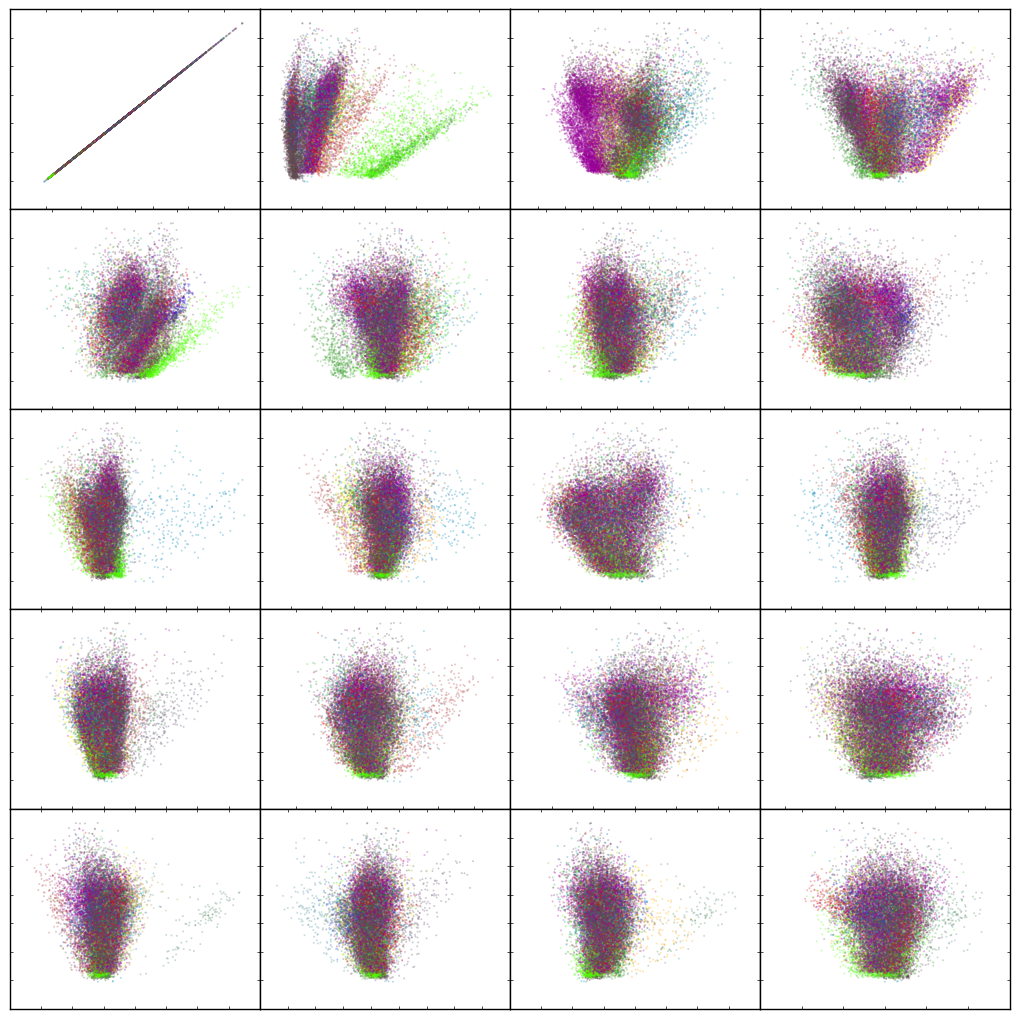

In [140]:
figure( figsize=(10,10))
#couple_pcs = list(combinations(range(6),2))
ccc = 0.3*cm.prism(labels/max(labels)) + 0.7*cm.spectral(labels/max(labels))
for i, a in enumerate(range(20)):
    ax = subplot(5,4,i+1)
    scatter(  pcs[i,:],pcs[0,:],s=2, c=ccc, lw=0, alpha=0.3)
    ax.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False, size=2)
    
tight_layout(pad=0.01, h_pad=0.01, w_pad=0.01)

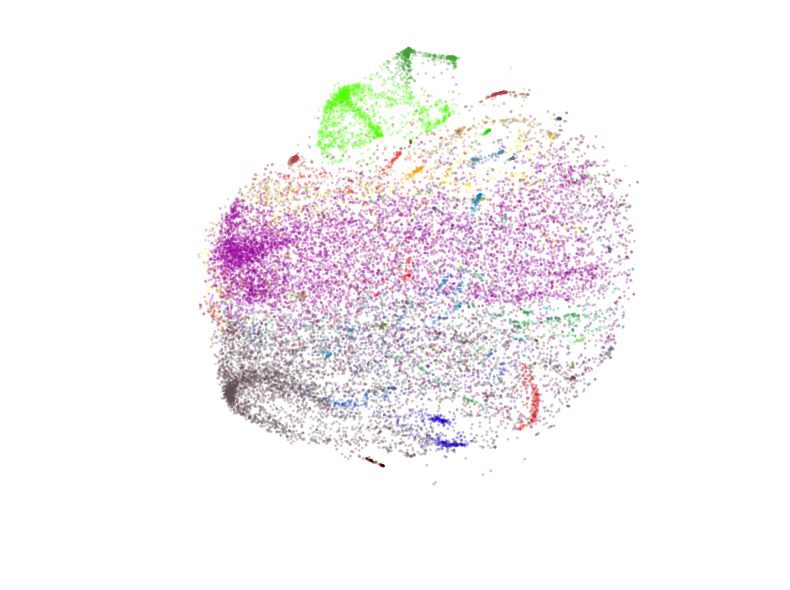

In [148]:
figure(figsize=(8,6))
scatter(tsne_pos[:,0],tsne_pos[:,1], alpha=0.3, s=4, lw=0, c=ccc)
axis("off")
tight_layout()

In [ ]:
# Marker enrichment and trinarization
f = 0.2
pep = 0.05
(enrichment, trinary_prob, trinary_pat) = cg.expression_patterns(ds, labels_all[cells], pep, f, cells)
#save_diff_expr(ds, build_dir, tissue, enrichment, trinary_pat, trinary_prob)

In [129]:
def gini_impurity(data: np.ndarray, labels: np.ndarray, kind: str="both"):
    """Efficient implementation to calculate Gini impurity for every threshold in the data range
    This calculates only yhr Right Gini impurity index
    This is a metric used in decision trees (less is better).

    Args 
    ____
        data: np.array1d(dtype=float|int)
            the data vector
        labels np.array1d(dtype=int)
            the labels vector
        kinds: "left", "right", "both"; default "both"
    Returns
    _______
        ginis: np.ndarray shape=(len(thresholds)) 
            Gini indexes
        thresholds: np.ndarray shape (~len(np.unique(data)))
            might be truncated and not go over all np.unique(data)

    """

    bins, ix_uniq, counts = np.unique(data, return_counts=True, return_inverse=True)
    ginis = np.zeros(bins.size-1)
    for i in range(1,bins.size):
        n = bins[i] # the value of the threshold
        # index_of_n = np.where( bins==n )[0][0] # the index of value of the threshold after ranking
        index_of_n = find_first(n,bins)
        
        if kind == "both" and i != 0:
            selec_r = labels[ix_uniq >= index_of_n ]
            selec_l = labels[ix_uniq < index_of_n ]
        elif kind =="left":
            selec = labels[ix_uniq < index_of_n ]
        elif kind == "right":
            selec = labels[ix_uniq >= index_of_n ]
        else:
            selec = labels[ix_uniq >= index_of_n ]
        
        if kind == "both" and i != 0:
            sum_sq_contks_l = np.sum(np.bincount(selec_l)**2)
            sq_N_l = len(selec_l)**2
            gini_l = 1 - (sum_sq_contks_l / sq_N_l)
            
            sum_sq_contks_r = np.sum(np.bincount(selec_r)**2)
            sq_N_r = len(selec_r)**2
            gini_r = 1 - (sum_sq_contks_r / sq_N_r)
            ginis[i-1] = gini_l + gini_r
        else:
            sum_sq_contks = np.sum(np.bincount(selec)**2)
            sq_N = len(selec)**2
            ginis[i-1] = 1 - (sum_sq_contks / sq_N)
    return ginis, bins[1:]

In [ ]:
import 

In [ ]:
np.random

In [ ]:




# Auto-annotation
logging.info("Auto-annotating cell types and states")
aa = cg.AutoAnnotator(ds, root=config["annotation"]["annotation_root"])
(tags, annotations) = aa.annotate(ds, trinary_prob)
sizes = np.bincount(labels_all + 1)
save_auto_annotation(build_dir, tissue, sizes, annotations, tags)

logging.info("Plotting clusters on graph")
plot_clusters(mknn, labels, tsne_pos, tags, annotations, title=tissue, plt_labels=True, outfile=os.path.join(build_dir, tissue + "_tSNE"))

logging.info("Saving attributes")
ds.set_attr("_tSNE_X", tsne_all[:, 0], axis=1)
ds.set_attr("_tSNE_Y", tsne_all[:, 1], axis=1)
ds.set_attr("Clusters", labels_all, axis=1)
ds.set_edges("MKNN", cells[mknn.row], cells[mknn.col], mknn.data, axis=1)
ds.set_edges("KNN", cells[knn.row], cells[knn.col], knn.data, axis=1)
logging.info("Done.")